In [2]:
from train_test import train, test

from sklearn.model_selection import train_test_split
import torch
import numpy as np
import pandas as pd
from torch import nn
import torch
import torch.nn.functional as F
import math

import matplotlib.pyplot as plt
import seaborn as sns

import pylab as pl

from dateutil.relativedelta import relativedelta

import shap

from captum.attr import IntegratedGradients, ShapleyValues, ShapleyValueSampling, LayerConductance

from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

torch.manual_seed(0)
np.random.seed(0)

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer

In [4]:
def output_to_accu(model, X, y):
    model.eval()
    prob = model(X).cpu().detach().numpy()
    index = np.where((prob > 0.5) | (prob < 0.5))
    prob = prob[index]
    y = y[index]
    pred = (prob >= 0.5).astype(int)
    nb_errors = 0
    for b in range(0, len(y)):
        if pred[b] != y[b]:
            nb_errors = nb_errors + 1
    accuracy = 100 * (1 - nb_errors / len(y))
    return accuracy

In [5]:
def output_to_accu_sklearn(model, X, y):
    prob = model.predict_proba(X)[:, 1]
    index = np.where((prob > 0.55) | (prob < 0.45))
    prob = prob[index]
    y = y[index]
    pred = (prob >= 0.5).astype(int)
    nb_errors = 0
    for b in range(0, len(y)):
        if pred[b] != y[b]:
            nb_errors = nb_errors + 1
    accuracy = (1 - nb_errors / len(y))
    return accuracy

In [6]:
def good_bad_pred(model, X_test, y_test):
    model.eval()
    prob = model(X_test).detach().numpy()
    pred = (prob >= 0.5).astype(int)
    return (pred == y_test.detach().numpy()).astype(int)

In [7]:
def good_bad_pred_sklearn(model, X_test, y_test):
    pred = model.predict(X_test)
    return (pred == y_test).astype(int)

In [8]:
def fast_fracdiff(x, d):
    T = len(x)
    np2 = int(2 ** np.ceil(np.log2(2 * T - 1)))
    k = np.arange(1, T)
    b = (1,) + tuple(np.cumprod((k - d - 1) / k))
    z = (0,) * (np2 - T)
    z1 = b + z
    z2 = tuple(x) + z
    dx = pl.ifft(pl.fft(z1) * pl.fft(z2))
    return np.real(dx[0:T])

In [9]:
def log_change(x):
    return np.log(x[-1] / x[0]) / len(x)

def pct_change(x):
    return (x[-1] - x[0]) / x[0]

In [10]:
red = sns.color_palette('RdYlGn', 10)[0]
green = sns.color_palette('RdYlGn', 10)[-1]
pal = [red, green]
color_dict = {'Bad':pal[0], 'Good':pal[1]}

# DATA

In [11]:
data = pd.read_excel('data/data.xlsx', index_col=0, skiprows=[0, 1, 2, 3, 4, 5, 6, 8], sheet_name='features').astype(float)
data = data.fillna(method='ffill').shift(1).iloc[1:]
data = data.loc[:'2020-01-01']

data['MATERIALS'] *= data['EURCHF']
data['CONSUMER STAPLE'] *= data['EURCHF']
data['INDUSTRIALS'] *= data['EURCHF']
data['CONSUMER DIS.'] *= data['EURCHF']
data['HEALTH CARE'] *= data['EURCHF']
data['FINANCIALS'] *= data['EURCHF']

data['GOLD'] *= data['USDCHF']
data['SILVER'] *= data['USDCHF']
data['BRENT'] *= data['USDCHF']
data['SP500'] *= data['USDCHF']
data['RUSSELL 2000'] *= data['USDCHF']

bench_price = data['SPI']

data = data.drop(columns=['EURCHF', 'USDCHF', 'SPI'])

data.head()

,SMALL_MID,LARGE,MATERIALS,CONSUMER STAPLE,INDUSTRIALS,CONSUMER DIS.,HEALTH CARE,FINANCIALS,US 2YEAR,US 5YEAR,US 10YEAR,GOLD,SILVER,BRENT,SP500,RUSSELL 2000,SURPRISE,VSMI,VIX
2006-01-05,1508.31,5833.18,276.409672,174.241453,218.695382,140.386529,175.355509,174.721116,4.304,4.277,4.344,679.214800,11.605220,78.703680,1624.934960,879.509796,24.4,13.04,11.37
2006-01-06,1509.53,5818.60,272.864640,172.733945,217.021928,139.568162,175.452705,173.846165,4.321,4.284,4.354,672.828960,11.181886,78.075236,1626.488656,883.552911,28.2,13.22,11.31
2006-01-09,1516.33,5828.32,274.390587,173.003134,217.791843,140.132384,175.331222,174.622003,4.354,4.316,4.375,685.399920,11.463555,79.666944,1632.778590,888.382961,25.3,13.10,11.00
2006-01-10,1518.68,5823.36,274.741194,172.954918,217.963610,140.964506,175.453688,175.052650,4.345,4.302,4.367,699.485820,11.715558,79.180569,1647.392535,901.822117,26.3,13.53,11.13
2006-01-11,1512.24,5785.15,271.683725,173.365830,217.371702,140.438683,174.153856,173.844827,4.395,4.358,4.426,694.241856,11.468668,79.300944,1651.705983,910.590507,26.4,14.18,10.86


In [12]:
target_prices = data[['SMALL_MID', 'LARGE']]
target_prices.head()

,SMALL_MID,LARGE
2006-01-05,1508.31,5833.18
2006-01-06,1509.53,5818.60
2006-01-09,1516.33,5828.32
2006-01-10,1518.68,5823.36
2006-01-11,1512.24,5785.15


In [13]:
technical_features = data[['SMALL_MID', 'LARGE']]

mom5 = technical_features.rolling(5).apply(lambda x: log_change(x))
mom5 = mom5.add_suffix(' mom5')

mom21 = technical_features.rolling(21).apply(lambda x: log_change(x))
mom21 = mom21.add_suffix(' mom21')

mom63 = technical_features.rolling(63).apply(lambda x: log_change(x))
mom63 = mom63.add_suffix(' mom63')

vol21 = technical_features.pct_change().rolling(21).std()
vol21 = vol21.add_suffix(' vol21')

skew21 = technical_features.pct_change().rolling(21).skew()
skew21 = skew21.add_suffix(' skew21')

corr = target_prices.SMALL_MID.pct_change().rolling(21).corr(target_prices.LARGE.pct_change()).rename('correlation')

features = pd.DataFrame(index=technical_features.index)
for feature in ['MATERIALS', 'SP500', 'BRENT', 'FINANCIALS', 'GOLD', 'US 5YEAR', 
                                'US 2YEAR', 'INDUSTRIALS', 'US 10YEAR', 'CONSUMER DIS.', 'HEALTH CARE', 
                                'CONSUMER STAPLE', 'RUSSELL 2000', 'SILVER']:
    #features[feature] = fast_fracdiff(data[feature], 0.5)
    features[feature] = data[feature].rolling(5).apply(lambda x: log_change(x))

features = pd.concat([mom5, mom21, mom63, vol21, skew21, corr, features, data[['SURPRISE', 'VSMI', 'VIX']]], axis=1).ewm(5).mean().dropna()

features.head(5)

,SMALL_MID mom5,LARGE mom5,SMALL_MID mom21,LARGE mom21,SMALL_MID mom63,LARGE mom63,SMALL_MID vol21,LARGE vol21,SMALL_MID skew21,LARGE skew21,correlation,MATERIALS,SP500,BRENT,FINANCIALS,GOLD,US 5YEAR,US 2YEAR,INDUSTRIALS,US 10YEAR,CONSUMER DIS.,HEALTH CARE,CONSUMER STAPLE,RUSSELL 2000,SILVER,SURPRISE,VSMI,VIX
2006-04-03,0.001734,-0.000138,0.001987,0.000582,0.001972,0.000648,0.004805,0.005994,-0.681978,0.413390,0.550245,0.002142,-0.000306,0.004831,0.000012,0.003677,0.002804,0.002220,0.001047,0.002904,0.000693,-0.000045,-0.000726,0.002206,0.007500,-5.650111,12.005423,11.450572
2006-04-04,0.001879,0.000316,0.002005,0.000638,0.002031,0.000723,0.004822,0.005864,-0.677942,0.450865,0.549831,0.002988,-0.000034,0.005074,0.000644,0.004428,0.002669,0.002203,0.001774,0.002987,0.000980,0.000287,-0.000390,0.002292,0.009026,-4.391748,11.984519,11.470477
2006-04-05,0.002176,0.000543,0.002121,0.000708,0.002041,0.000715,0.004835,0.005769,-0.674858,0.486732,0.547301,0.003563,-0.000435,0.004168,0.000875,0.004309,0.002363,0.001960,0.002144,0.002903,0.000936,0.000160,-0.000256,0.001344,0.009227,-3.009780,11.990433,11.415397
2006-04-06,0.002428,0.000679,0.002302,0.000829,0.002060,0.000741,0.004711,0.005658,-0.614796,0.501623,0.533222,0.003521,-0.000464,0.003403,0.000808,0.003512,0.001699,0.001412,0.002026,0.002336,0.000755,-0.000080,-0.000380,0.000890,0.008279,-1.824810,11.998694,11.367831
2006-04-07,0.002594,0.000873,0.002454,0.000916,0.002100,0.000792,0.004508,0.005548,-0.487867,0.501397,0.515718,0.003883,-0.000382,0.003438,0.000878,0.003212,0.001589,0.001301,0.001985,0.002303,0.000671,-0.000235,-0.000522,0.000429,0.007813,-0.754003,11.987245,11.381526


# Train-Validation dataset

In [14]:
neutral_threshold = 0.0005

forward_weekly_returns = target_prices.rolling(5).apply(lambda x: np.log(x[-1] / x[0]) / len(x)).shift(-5)
forward_weekly_returns['difference'] = forward_weekly_returns.SMALL_MID - forward_weekly_returns.LARGE
forward_weekly_returns['abs_diff'] = np.abs(forward_weekly_returns.difference)

best_pred = (forward_weekly_returns.SMALL_MID > forward_weekly_returns.LARGE).astype(int)
best_pred = best_pred[forward_weekly_returns.abs_diff > neutral_threshold]

start_date = '2009-01-01'
split_date = '2012-12-31'
end_date = '2013-11-20'

df_output = best_pred.loc[start_date:end_date]
df_input = features.reindex(df_output.index)


y = df_output.values
index = df_output.index
features = features.reindex(index)
features_std = pd.DataFrame(data=PowerTransformer(method='yeo-johnson', standardize=True).fit_transform(features), columns=features.columns)
X = features_std.values

split_index = index.get_loc(split_date, method='ffill')
X_train, y_train, X_test, y_test = X[:split_index], y[:split_index], X[split_index:], y[split_index:]

print('start_date', index[0].date(), '; split date', index[len(X_train)].date(), '; last_date', index[-1].date())

print('Number of train sample :', len(X_train))
print('Number of test sample :', len(X_test))

class_count_train = np.unique(y_train, axis=0, return_counts=True)[1]
class_count_test = np.unique(y_test, axis=0, return_counts=True)[1]
weights_train = class_count_train / sum(class_count_train)
weights_test = class_count_test / sum(class_count_test)
print('Allocation of best returns in train set :', weights_train)
print('Allocation of best returns in test set :', weights_test)

#X_mean = X_train.mean(axis=0)
#X_std = X_train.std(axis=0)
#X_train = (X_train - X_mean) / X_std
#X_test = (X_test - X_mean) / X_std

start_date 2009-01-01 ; split date 2012-12-31 ; last_date 2013-11-20
Number of train sample : 819
Number of test sample : 178
Allocation of best returns in train set : [0.505 0.495]
Allocation of best returns in test set : [0.506 0.494]


# CORRELATION

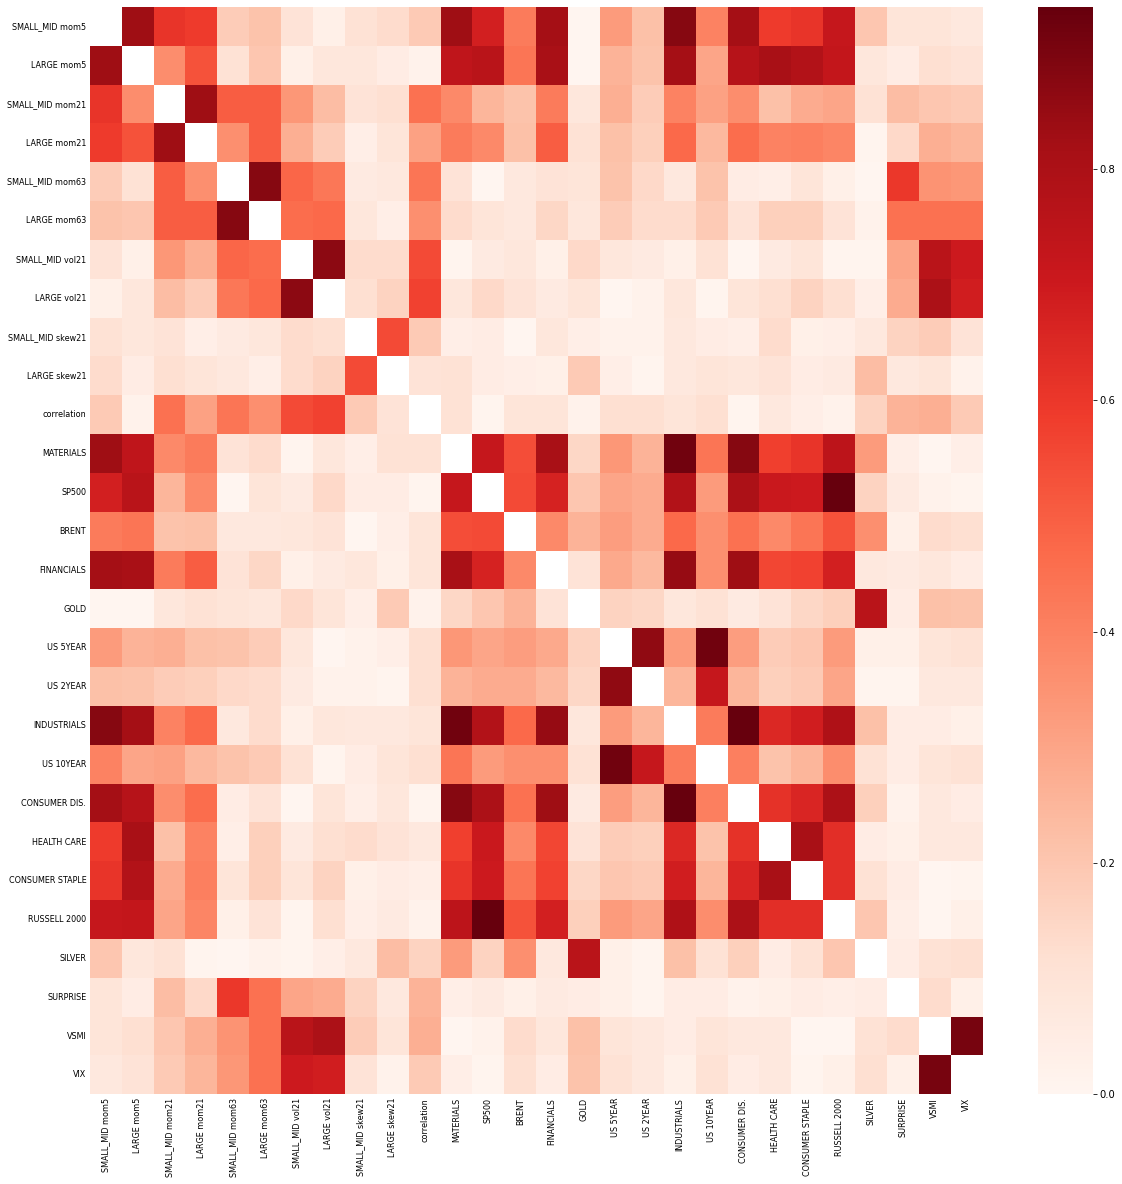

In [20]:
corr = features_std.corr().abs().round(2)

fig, ax = plt.subplots(figsize=(20, 20))
mask = np.identity(len(corr))
sns.heatmap(data=corr, annot=False, cmap='Reds', cbar=True, mask=mask, annot_kws=dict(size=12))
ax.tick_params(axis='both', which='major', labelsize=8, labelbottom=True, labeltop=False, labelleft=True, length=0)
plt.savefig('plots/latex/correlation_matrix.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

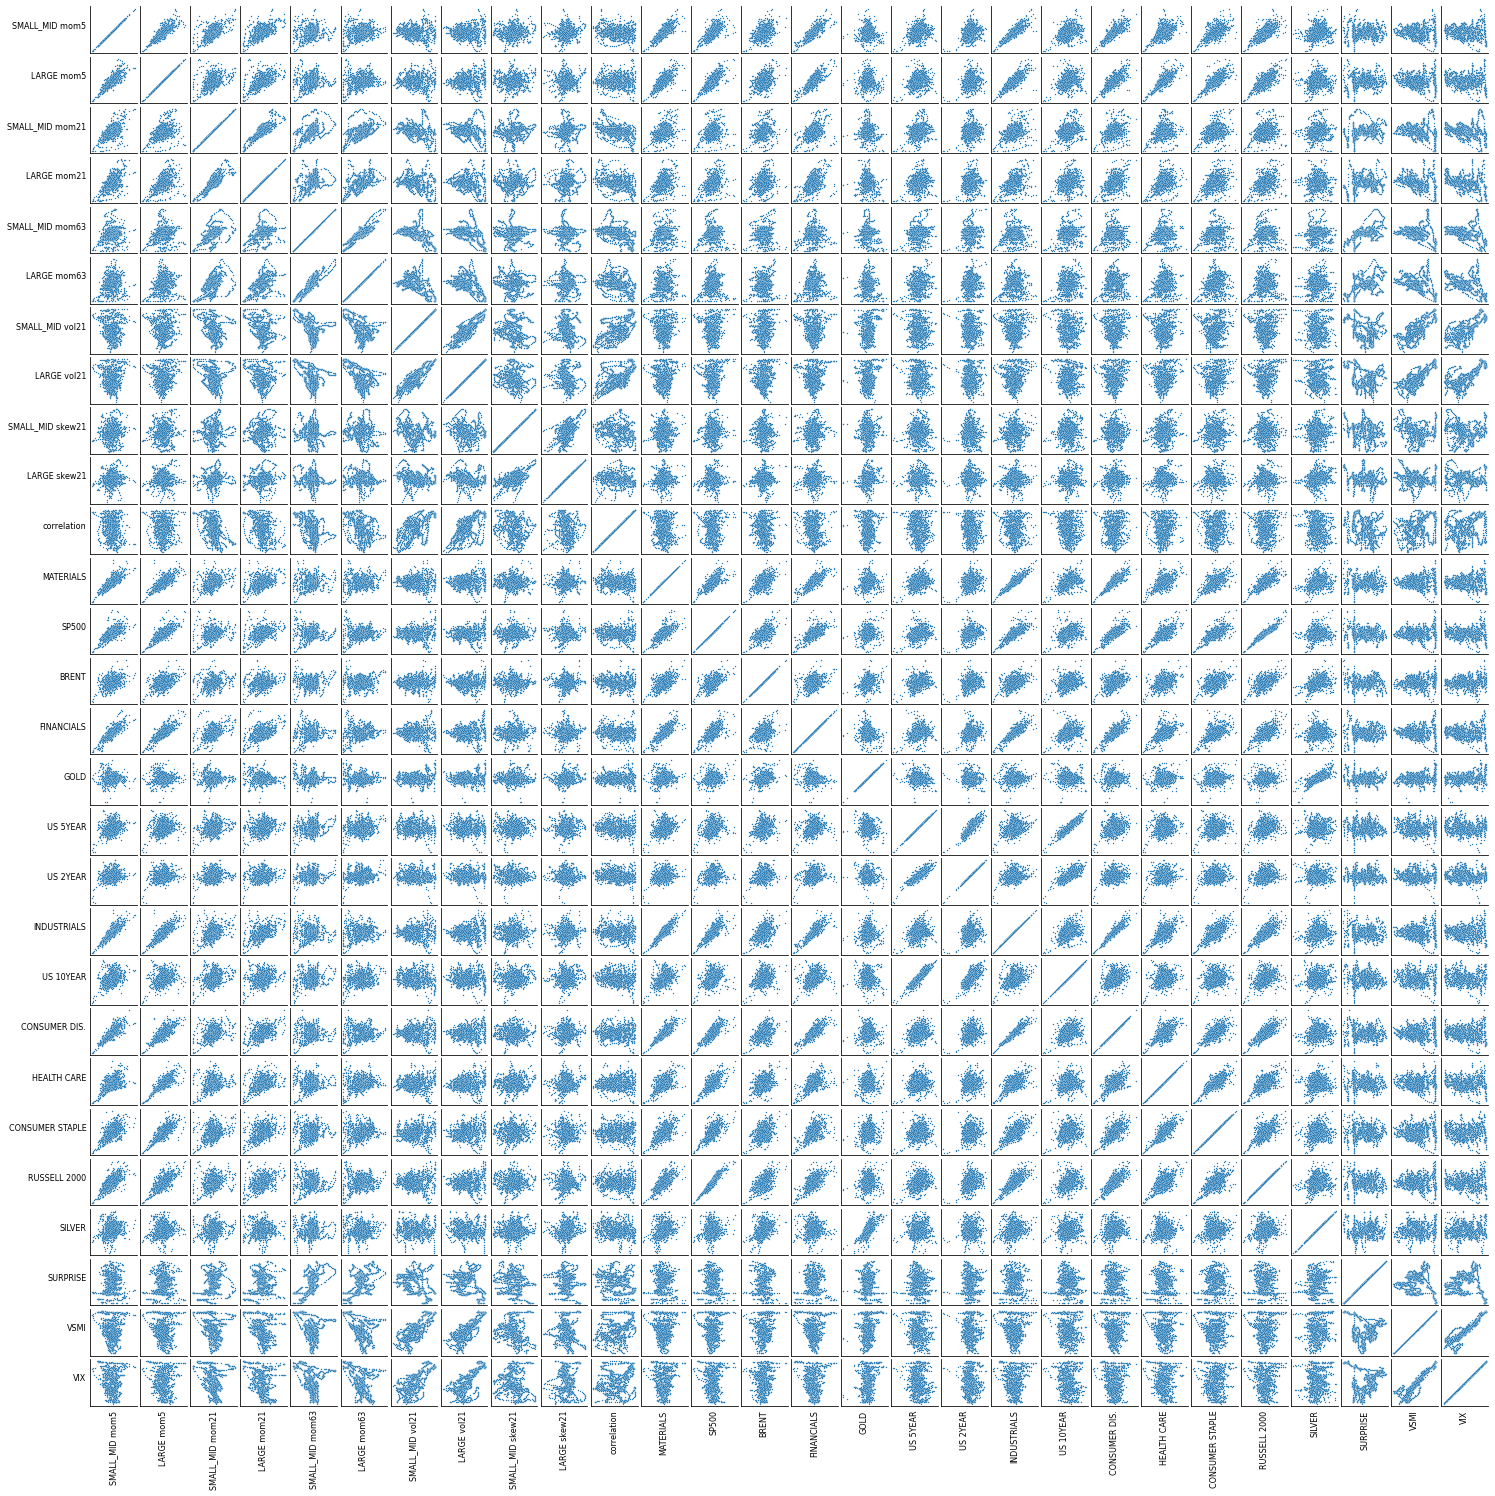

In [17]:
pairplot_data = pd.DataFrame(features_std[features.columns[:]], columns=features.columns[:])

g = sns.pairplot(data=pairplot_data, plot_kws={'s': 2}, diag_kind=None)
g.figure.set_size_inches(20, 20)
plt.setp(g.axes, xticks=[], yticks=[])
for ax in g.axes.flatten():
    ax.set_xlabel(ax.get_xlabel(), fontsize=8, rotation=90)
    ax.set_ylabel(ax.get_ylabel(), fontsize=8, rotation=0)
    ax.yaxis.get_label().set_horizontalalignment('right')

plt.savefig('plots/latex/bivariate.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# PCA

In [21]:
from sklearn.decomposition import PCA

In [22]:
pca = PCA(n_components=20)
pca.fit(features_std)

PCA(n_components=20)

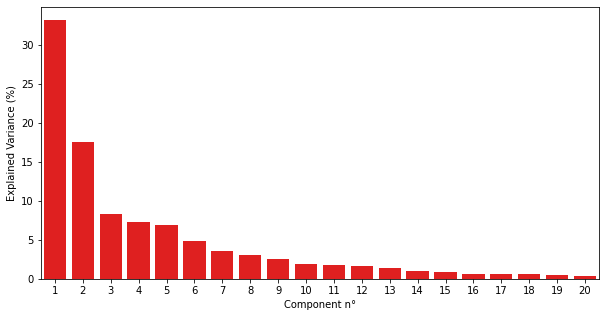

In [62]:
explained_variance = pca.explained_variance_ratio_

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=np.arange(20) + 1, y=100 * explained_variance, orient='v', color='red')
#plt.plot(np.cumsum(explained_variance), label='Cumulative Explained Variance')
plt.xlabel('Component n°')
plt.ylabel('Explained Variance (%)')
plt.savefig('plots/latex/pca_components.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

In [81]:
explained_variance[:3].sum()

0.5896602228978004

In [26]:
loadings = pca.components_.T[:, :4]
df_loadings = pd.DataFrame(loadings, columns=['PC1', 'PC2', 'PC3', 'PC4'], index=features.columns)

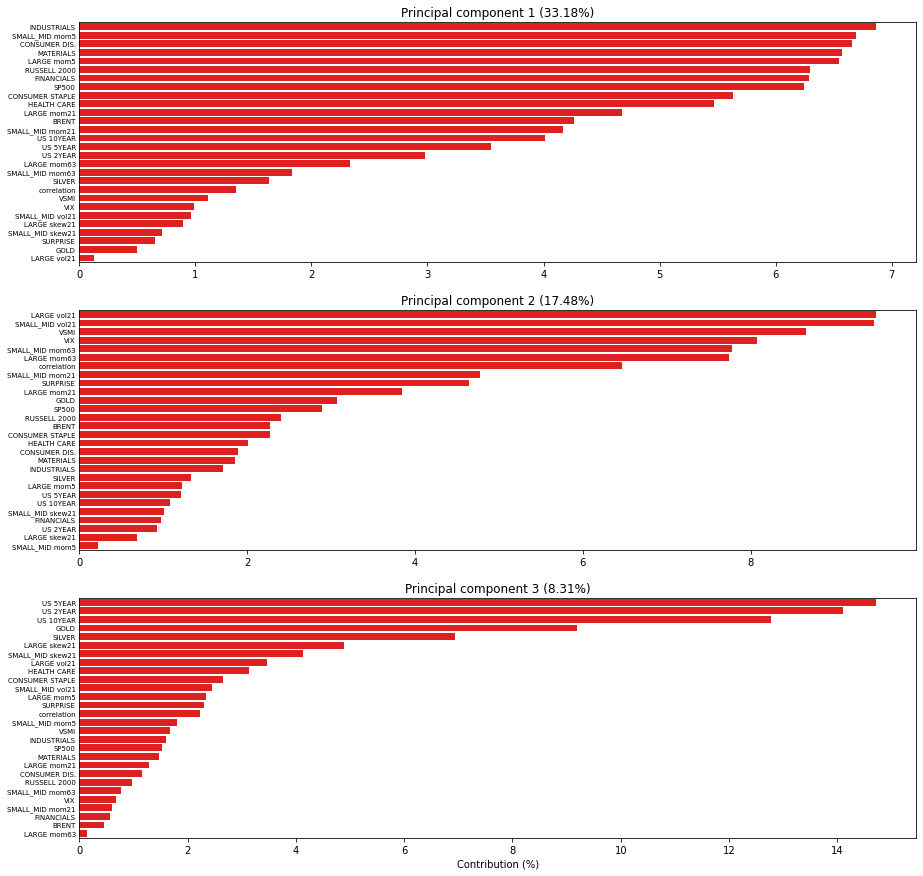

In [63]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15), sharex=False)

pca_importance = df_loadings.PC1.abs().sort_values(ascending=False)
pca_importance = 100 * pca_importance / pca_importance.sum()
sns.barplot(ax=axs[0], y=pca_importance.index, x=pca_importance.values, color='red')
axs[0].tick_params(axis='y', labelsize=7, length=0)
#axs[0].set_xlabel('Contribution (%)')
axs[0].set_title(f'Principal component 1 ({100 * explained_variance[0]:.2f}%)')

pca_importance = df_loadings.PC2.abs().sort_values(ascending=False)
pca_importance = 100 * pca_importance / pca_importance.sum()
sns.barplot(ax=axs[1], y=pca_importance.index, x=pca_importance.values, color='red')
axs[1].tick_params(axis='y', labelsize=7, length=0)
#axs[1].set_xlabel('Contribution (%)')
axs[1].set_title(f'Principal component 2 ({100 * explained_variance[1]:.2f}%)')
    
pca_importance = df_loadings.PC3.abs().sort_values(ascending=False)
pca_importance = 100 * pca_importance / pca_importance.sum()
sns.barplot(ax=axs[2], y=pca_importance.index, x=pca_importance.values, color='red')
axs[2].tick_params(axis='y', labelsize=7, length=0)
axs[2].set_xlabel('Contribution (%)')
axs[2].set_title(f'Principal component 3 ({100 * explained_variance[2]:.2f}%)')

plt.savefig('plots/latex/pca_features_contrib.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# LOGIT REGRESSION

In [84]:
logreg = LogisticRegression(penalty='l2', class_weight='balanced')

logreg = logreg.fit(X_train, y_train)
y_hat_logreg_train = logreg.predict(X_train)
y_hat_logreg_test = logreg.predict(X_test)

print('Accuracy on train set', round(100 * output_to_accu_sklearn(logreg, X_train, y_train), 2), '%')
print('Accuracy on test set', round(100 * output_to_accu_sklearn(logreg, X_test, y_test), 2), '%')

Accuracy on train set 70.32 %
Accuracy on test set 50.3 %


Permutation explainer: 820it [00:17, 26.62it/s]                         


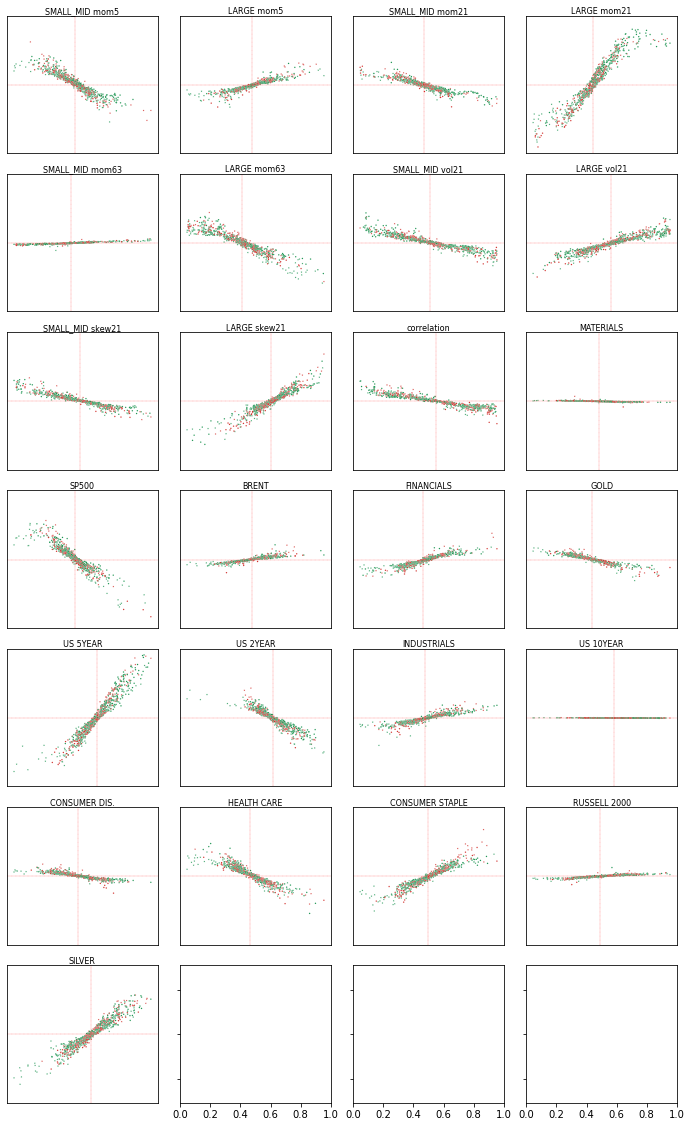

In [26]:
explainer = shap.Explainer(logreg.predict, X_train)
shap_values_train = explainer(X_train).values
good_bad = good_bad_pred_sklearn(logreg, X_train, y_train)

fig, axs = plt.subplots(math.ceil(len(features.columns) / 4), 4, figsize=(12, 20), sharex=False, sharey=True)

axs = axs.ravel()

for i, feature in enumerate(features.columns):
    df = pd.DataFrame()
    df['value'] = X_train[:, i]
    df['IG'] = shap_values_train[:, i]
    df['good_bad'] = good_bad
    df['target'] = y_train
    df.good_bad = df.good_bad.replace({0:'Bad', 1:'Good'})
    df.target = df.target.replace({0:'Large', 1:'Small'})
    
    sns.scatterplot(ax=axs[i], data=df, x='value', y='IG', hue='good_bad', style='target', s=2, legend=False, palette=color_dict)
    axs[i].axhline(y=0., linestyle='--', color='r', lw=0.25)
    axs[i].axvline(x=0., linestyle='--', color='r', lw=0.25)
    axs[i].set_xlabel(None)
    axs[i].set_ylabel(None)
    axs[i].tick_params(axis='both', length=0, labelbottom=False, labelleft=False)
    axs[i].set_title(feature, fontsize=8, pad=2)

plt.subplots_adjust(wspace=0.15, hspace=0.15)
    
plt.savefig('plots/LOGIT_features_importances_train2.png', dpi=300, facecolor='white', bbox_inches='tight')
plt.show()

# Random Forest

In [31]:
rf_n_estimators = [1000]
rf_max_depth = [5, 10, 20]
rf_max_depth.append(None)
rf_min_samples_leaf = [1, 5, 10]
rf_min_samples_split = [2, 10, 20]

rf_grid = {'n_estimators'     : rf_n_estimators,
           'max_depth'        : rf_max_depth, 
           'min_samples_leaf' : rf_min_samples_leaf, 
           'min_samples_split': rf_min_samples_split }

tuning_list = []
for n_estimators in tqdm(rf_n_estimators, leave=False):
    for max_depth in tqdm(rf_max_depth, leave=False):
        for samples_leaf in tqdm(rf_min_samples_leaf, leave=False):
            for samples_split in tqdm(rf_min_samples_split, leave=False):
                estimator = RandomForestClassifier(max_depth=max_depth, min_samples_leaf=samples_leaf, 
                                                     min_samples_split=samples_split, n_estimators=n_estimators, random_state=1)
                estimator.fit(X_train, y_train)
                tuning_list.append([n_estimators, max_depth, samples_leaf, samples_split,
                                    np.round(100 * output_to_accu_sklearn(estimator, X_test, y_test), 2)])
                
display(pd.DataFrame(data=tuning_list, columns=['n_estimators', 'max_depth', 'samples_leaf',
                                                'samples_split', 'Accuracy']).sort_values('Accuracy'))


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


  0%|          | 0/3 [00:00<?, ?it/s]


 33%|███▎      | 1/3 [00:04<00:09,  4.57s/it]


 67%|██████▋   | 2/3 [00:08<00:04,  4.15s/it]


100%|██████████| 3/3 [00:12<00:00,  4.19s/it]


 33%|███▎      | 1/3 [00:12<00:25, 12.57s/it]


  0%|          | 0/3 [00:00<?, ?it/s]


 33%|███▎      | 1/3 [00:04<00:08,  4.28s/it]


 67%|██████▋   | 2/3 [00:08<00:04,  4.20s/it]


100%|██████████| 3/3 [00:12<00:00,  4.21s/it]


 67%|██████▋   | 2/3 [00:25<00:12, 12.62s/it]


  0%|          | 0/3 [00:00<?, ?it/s]


 33%|███▎      | 1/3 [00:04<00:08,  4.34s/it]


 67%|██████▋   | 2/3 [00:08<00:04,  4.31s/it]


100%|██████████| 3/3 [00:12<00:00,  4.15s/it]


100%|██████████| 3/3 [00:37<00:00, 12.56s/it]

 25%|██▌       | 1/4 [00:37<01:53, 37.69s/it]

  0%|          | 0/3 [00:00<?, ?it/s]


  0%|          | 0/3 [00:00<?, ?it/s]


 33%|███▎      | 1/3 [00:05<00:10,  5.38s/it]


 67%|██████▋   | 2/3 [00:10<00:05,  5.33s/it]


100

,n_estimators,max_depth,samples_leaf,samples_split,Accuracy
13,1000,10.0,5,10,51.69
12,1000,10.0,5,2,51.69
17,1000,10.0,10,20,52.81
22,1000,20.0,5,10,52.81
23,1000,20.0,5,20,52.81
16,1000,10.0,10,10,52.81
15,1000,10.0,10,2,52.81
14,1000,10.0,5,20,52.81
11,1000,10.0,1,20,52.81
21,1000,20.0,5,2,52.81


In [85]:
rfc = RandomForestClassifier(n_estimators=1000, max_depth=5, min_samples_leaf=1, 
                             min_samples_split=2)

rfc = rfc.fit(X_train, y_train)

print('Accuracy on train set', round(100 * output_to_accu_sklearn(rfc, X_train, y_train), 2), '%')
print('Accuracy on test set', round(100 * output_to_accu_sklearn(rfc, X_test, y_test), 2), '%')

Accuracy on train set 94.0 %
Accuracy on test set 56.52 %


In [35]:
importances = rfc.feature_importances_
explainer = shap.TreeExplainer(rfc)
shap_values_train = explainer.shap_values(X_train)[1]

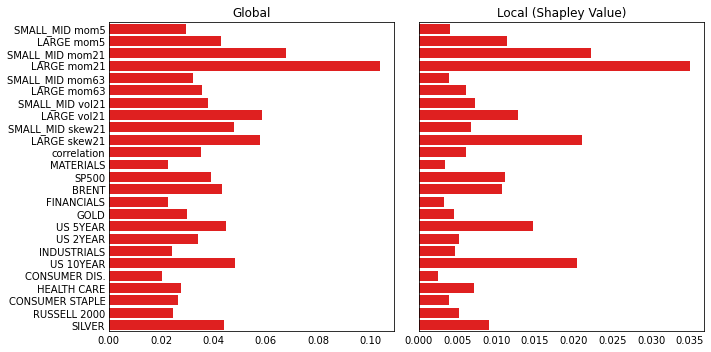

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

sns.barplot(ax=axs[0], x=importances, y=features.columns, color='r')
axs[0].tick_params(length=0)
axs[0].set_title('Global')

sns.barplot(ax=axs[1], x=np.abs(shap_values_train).mean(axis=0), y=features.columns, color='r')
axs[1].tick_params(length=0)
axs[1].set_title('Local (Shapley Value)')

plt.tight_layout()
plt.show()

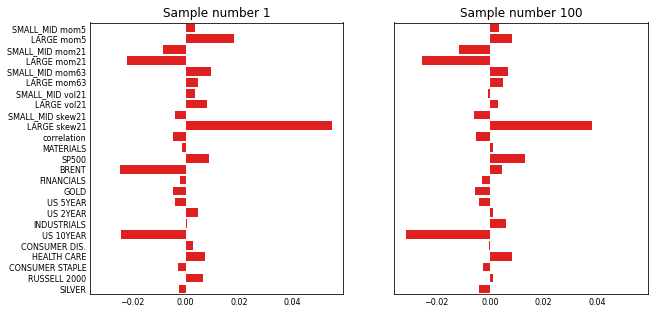

In [37]:
list_indices = [0, 99]
fig, axs = plt.subplots(1, len(list_indices), figsize=(10, 5), sharey=True, sharex=True)
for i, indice in enumerate(list_indices):
    sns.barplot(ax=axs[i], x=shap_values_train[i], y=features.columns, color='r')
    axs[i].tick_params(length=0, labelsize=8)
    axs[i].set_title('Sample number ' + str(indice + 1))

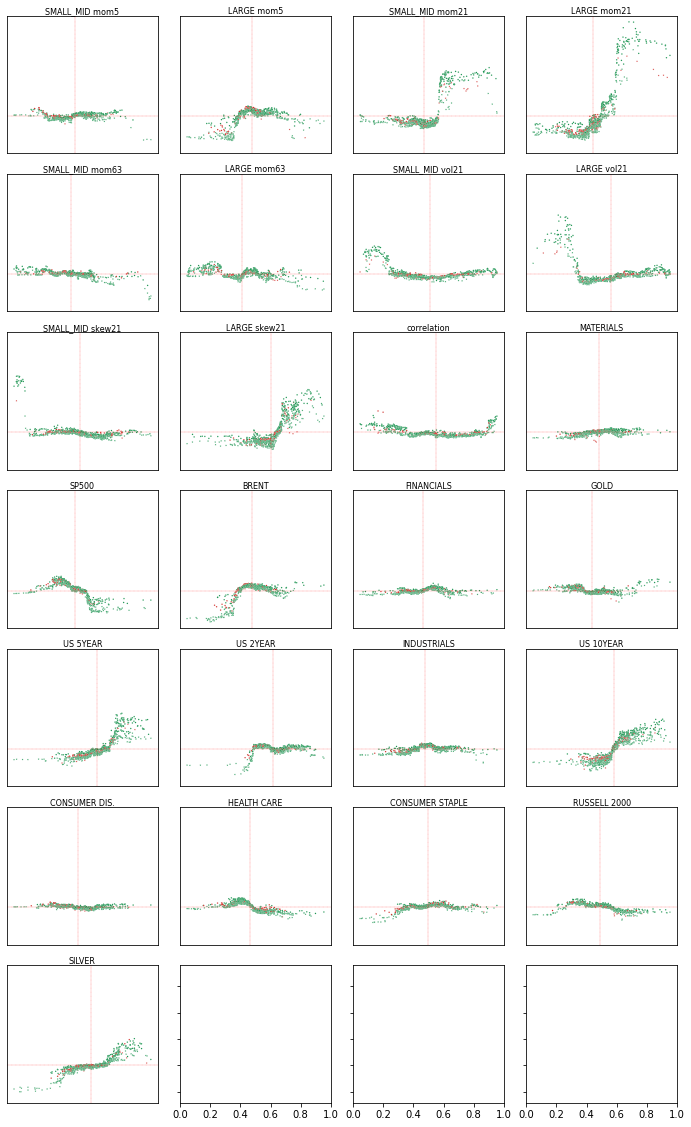

In [38]:
shap_values = shap_values_train
good_bad = good_bad_pred_sklearn(rfc, X_train, y_train)

fig, axs = plt.subplots(math.ceil(len(features.columns) / 4), 4, figsize=(12, 20), sharex=False, sharey=True)

axs = axs.ravel()

for i, feature in enumerate(features.columns):
    df = pd.DataFrame()
    df['value'] = X_train[:, i]
    df['IG'] = shap_values_train[:, i]
    df['good_bad'] = good_bad
    df['target'] = y_train
    df.good_bad = df.good_bad.replace({0:'Bad', 1:'Good'})
    df.target = df.target.replace({0:'Large', 1:'Small'})
    
    sns.scatterplot(ax=axs[i], data=df, x='value', y='IG', hue='good_bad', style='target', s=2, legend=False, palette=color_dict)
    axs[i].axhline(y=0., linestyle='--', color='r', lw=0.25)
    axs[i].axvline(x=0., linestyle='--', color='r', lw=0.25)
    axs[i].set_xlabel(None)
    axs[i].set_ylabel(None)
    axs[i].tick_params(axis='both', length=0, labelbottom=False, labelleft=False)
    axs[i].set_title(feature, fontsize=8, pad=2)

plt.subplots_adjust(wspace=0.15, hspace=0.15)
    
plt.savefig('plots/RF_features_importances_train.png', dpi=300, facecolor='white', bbox_inches='tight')
plt.show()

# XGBOOST

In [369]:
xg_n_estimators = [1000, 2000]
xg_max_depth = [1, 2]
xg_learning_rate = [0.05, 0.01]

tuning_list = []
for n_estimators in tqdm(xg_n_estimators, position=0, leave=None):
    for max_depth in tqdm(xg_max_depth, position=1, leave=None):
        for lr in tqdm(xg_learning_rate, position=2, leave=None):
            estimator = GradientBoostingClassifier(max_depth=max_depth, learning_rate=lr, 
                                                   n_estimators=n_estimators, random_state=1)
            estimator.fit(X_train, y_train)
            tuning_list.append([max_depth, lr, n_estimators,
                                np.round(100 * output_to_accu_sklearn(estimator, X_test, y_test), 2)])
                
display(pd.DataFrame(data=tuning_list, columns=['max_depth', 'learning_rate', 'n_estimators',
                                                'Accuracy']).sort_values('Accuracy'))



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:01<00:01,  1.70s/it]

100%|██████████| 2/2 [00:03<00:00,  1.66s/it]

                                             
 50%|█████     | 1/2 [00:03<00:03,  3.27s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:02<00:02,  2.91s/it]

100%|██████████| 2/2 [00:05<00:00,  2.92s/it]

                                             
  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:03<00:03,  3.36s/it]

100%|██████████| 2/2 [00:06<00:00,  3.36s/it]

                                             
 50%|█████     | 1/2 [00:06<00:06,  6.72s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:05<00:05,  5.71s/it]

100%|██████████| 2/2 [00:11<00:00,  5.81s/it]

                                             
100%|██████████| 2/2 [00:18<00:00,  8.23s/it]


,max_depth,learning_rate,n_estimators,Accuracy
6,2,0.05,2000,52.81
7,2,0.01,2000,53.37
0,1,0.05,1000,53.93
4,1,0.05,2000,55.06
5,1,0.01,2000,55.06
1,1,0.01,1000,56.18
2,2,0.05,1000,56.74
3,2,0.01,1000,58.43


In [39]:
xgboost = GradientBoostingClassifier(max_depth=1, n_estimators=1000, learning_rate=0.01)
xgboost = xgboost.fit(X_train, y_train)

print('Accuracy on train set', round(100 * output_to_accu_sklearn(xgboost, X_train, y_train), 2), '%')
print('Accuracy on test set', round(100 * output_to_accu_sklearn(xgboost, X_test, y_test), 2), '%')

Accuracy on train set 79.9 %
Accuracy on test set 55.71 %


In [40]:
importances = xgboost.feature_importances_

explainer = shap.TreeExplainer(xgboost)
shap_values_train = explainer.shap_values(X_train)

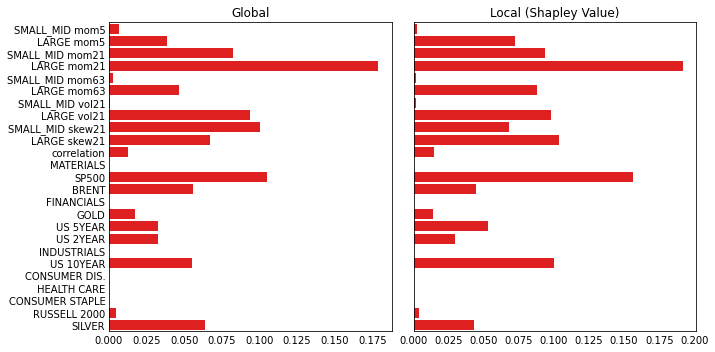

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

sns.barplot(ax=axs[0], x=importances, y=features.columns, color='r')
axs[0].tick_params(length=0)
axs[0].set_title('Global')

sns.barplot(ax=axs[1], x=np.abs(shap_values_train).mean(axis=0), y=features.columns, color='r')
axs[1].tick_params(length=0)
axs[1].set_title('Local (Shapley Value)')

plt.tight_layout()
plt.show()

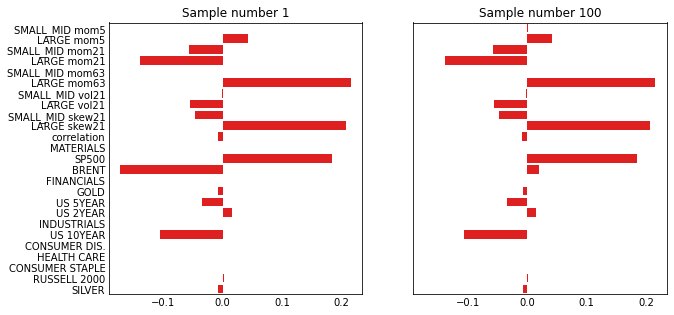

In [42]:
list_indices = [0, 99]
fig, axs = plt.subplots(1, len(list_indices), figsize=(10, 5), sharey=True, sharex=True)
for i, indice in enumerate(list_indices):
    sns.barplot(ax=axs[i], x=shap_values_train[i], y=features.columns, color='r')
    axs[i].tick_params(length=0)
    axs[i].set_title('Sample number ' + str(indice + 1))
    

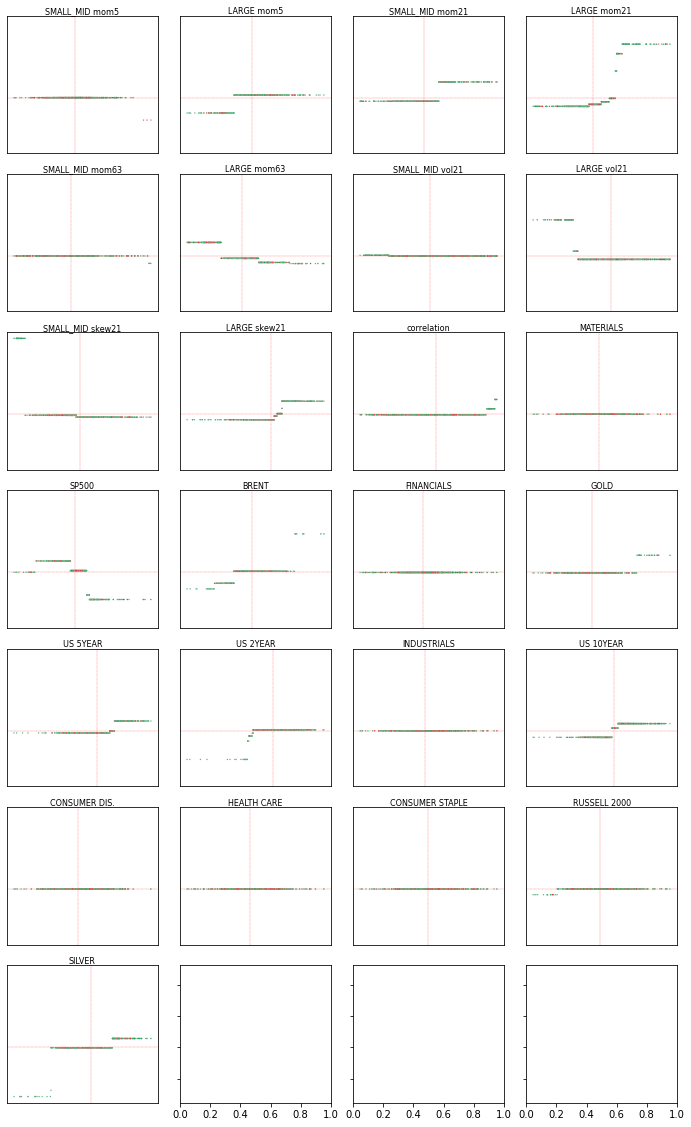

In [43]:
shap_values = shap_values_train
good_bad = good_bad_pred_sklearn(xgboost, X_train, y_train)

fig, axs = plt.subplots(math.ceil(len(features.columns) / 4), 4, figsize=(12, 20), sharex=False, sharey=True)

axs = axs.ravel()

for i, feature in enumerate(features.columns):
    df = pd.DataFrame()
    df['value'] = X_train[:, i]
    df['IG'] = shap_values_train[:, i]
    df['good_bad'] = good_bad
    df['target'] = y_train
    df.good_bad = df.good_bad.replace({0:'Bad', 1:'Good'})
    df.target = df.target.replace({0:'Large', 1:'Small'})
    
    sns.scatterplot(ax=axs[i], data=df, x='value', y='IG', hue='good_bad', style='target', s=2, legend=False, palette=color_dict)
    axs[i].axhline(y=0., linestyle='--', color='r', lw=0.25)
    axs[i].axvline(x=0., linestyle='--', color='r', lw=0.25)
    axs[i].set_xlabel(None)
    axs[i].set_ylabel(None)
    axs[i].tick_params(axis='both', length=0, labelbottom=False, labelleft=False)
    axs[i].set_title(feature, fontsize=8, pad=2)

plt.subplots_adjust(wspace=0.15, hspace=0.15)
    
plt.savefig('plots/XG_features_importances_train.png', dpi=300, facecolor='white', bbox_inches='tight')
plt.show()

# Neural Networks

In [163]:
class MLP(nn.Module):
    def __init__(self, nbr_features, hidden_size=10, pdrop=0.1):
        super().__init__()

        self.fc1 = nn.Linear(nbr_features, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, 1)
        
        self.drop1 = nn.Dropout(pdrop)
        self.drop2 = nn.Dropout(pdrop)
        self.drop3 = nn.Dropout(pdrop)
        
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        
        self.sigmoid = nn.Sigmoid()
        
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)

    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = self.relu1(self.bn1(self.drop1(self.fc1(x))))
        x = self.relu2(self.bn2(self.drop2(self.fc2(x))))
        x = self.relu3(self.drop3(self.fc3(x)))
        x = self.sigmoid(self.fc4(x))       

        return x.squeeze()

In [164]:
class MLP2(nn.Module):
    def __init__(self, nbr_features, pdrop=0.1, hidden_size=20):
        super().__init__()

        self.fc1 = nn.Linear(nbr_features, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        
        self.drop1 = nn.Dropout(pdrop)
        self.drop2 = nn.Dropout(pdrop)
        
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        
        self.sigmoid = nn.Sigmoid()
        
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)

    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = self.relu1(self.bn1(self.drop1(self.fc1(x))))
        x = self.relu2(self.bn2(self.drop2(self.fc2(x))))
        x = self.sigmoid(self.fc3(x))       

        return x.squeeze()

In [165]:
X_train, y_train, X_test, y_test = torch.from_numpy(X_train).float(), \
                                   torch.from_numpy(y_train).float(), \
                                   torch.from_numpy(X_test).float(), \
                                   torch.from_numpy(y_test).float()

In [166]:
eta = 1e-3
weight_decay = 1e-4
dropout = 0.1
batch_size = 20
nb_epochs = 50
hidden_size = 10
verbose = 3

nbr_features = X_train.size(1)

model_MLP = MLP(nbr_features, hidden_size=hidden_size, pdrop=dropout)

train(model_MLP, X_train, y_train, nb_epochs=nb_epochs, X_test=X_test, y_test=y_test, 
      batch_size=batch_size, eta=eta, weight_decay=weight_decay, verbose=verbose)

model_MLP.eval()

print('Number of parameters :', )
print(f' MLP Accuracy on train set : {output_to_accu(model_MLP, X_train, y_train):.2f} %')
print(f' MLP Accuracy on test set : {output_to_accu(model_MLP, X_test, y_test):.2f} %')

100%|██████████| 50/50 [00:03<00:00, 16.01it/s]

Number of parameters :
 MLP Accuracy on train set : 83.50 %
 MLP Accuracy on test set : 50.00 %


In [167]:
ig = IntegratedGradients(model_MLP)
attributes_train = ig.attribute(X_train, return_convergence_delta=False).detach().numpy()
attributes_test = ig.attribute(X_test, return_convergence_delta=False).detach().numpy()

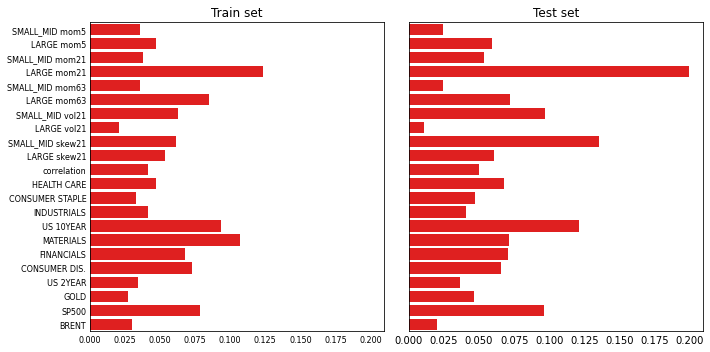

In [168]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

attr_train = np.mean(np.abs(attributes_train), axis=0)
attr_test = np.mean(np.abs(attributes_test), axis=0)

sns.barplot(ax=axs[0], x=attr_train, y=features.columns, color='r')
axs[0].tick_params(length=0, labelsize=8)
axs[0].set_title('Train set')

sns.barplot(ax=axs[1], x=attr_test, y=features.columns, color='r')
axs[1].tick_params(length=0)
axs[1].set_title('Test set')

plt.tight_layout()
plt.show()

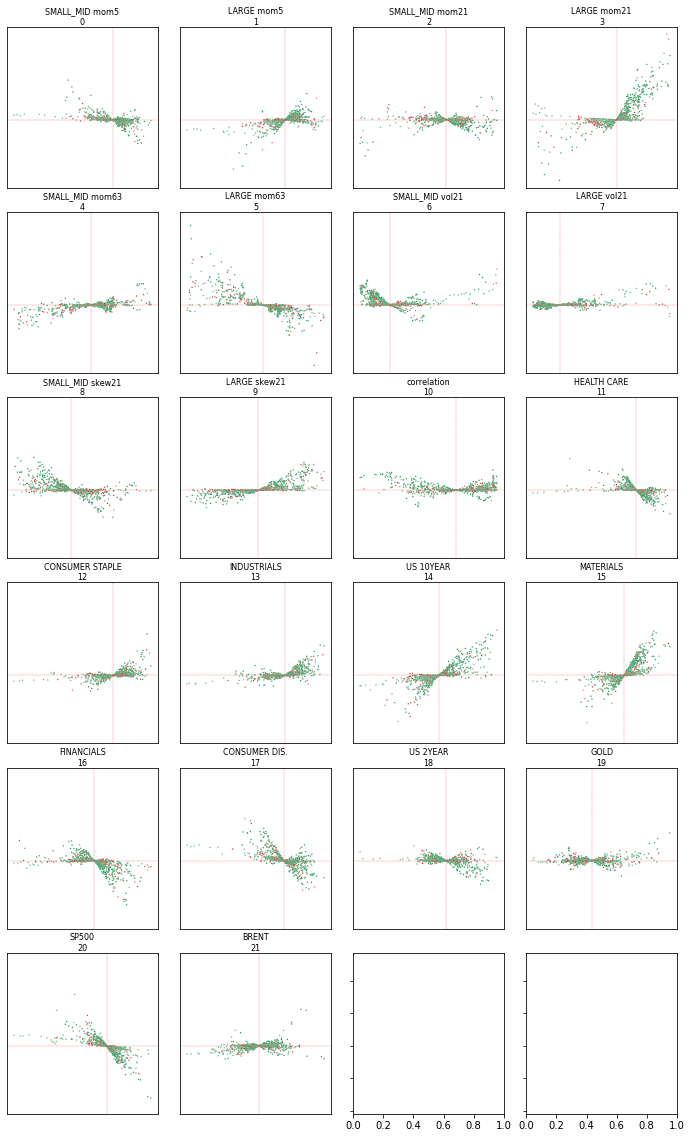

In [169]:
good_bad = good_bad_pred(model_MLP, X_train, y_train)

fig, axs = plt.subplots(math.ceil(len(features.columns) / 4), 4, figsize=(12, 20), sharex=False, sharey=True)
axs = axs.ravel()

for i, feature in enumerate(features.columns):
    df = pd.DataFrame(columns=['value', 'IG', 'good_bad', 'target', 'categorie'])
    df['value'] = X_train[:, i]
    df['IG'] = attributes_train[:, i]
    df['good_bad'] = good_bad
    df['target'] = y_train
    df.good_bad = df.good_bad.replace({0:'Bad', 1:'Good'})
    df.target = df.target.replace({0:'Large', 1:'Small'})
    
    sns.scatterplot(ax=axs[i], data=df, x='value', y='IG', hue='good_bad', style='target', s=2, legend=False,
                    palette=color_dict, edgecolors=None)
    
    axs[i].axvline(x=0., linestyle='--', color='r', lw=0.25)
    axs[i].axhline(y=0., linestyle='--', color='r', lw=0.25)
    axs[i].set_xlabel(None)
    axs[i].set_ylabel(None)
    axs[i].tick_params(axis='both', length=0, labelbottom=False, labelleft=False)
    axs[i].set_title(feature + '\n' + str(i), fontsize=8, pad=2)

# fig.delaxes(axs[-3])
# fig.delaxes(axs[-2])
# fig.delaxes(axs[-1])

plt.subplots_adjust(wspace=0.15, hspace=0.15)

plt.savefig('plots/MLP_features_importances_train.png', format='png', bbox_inches='tight', dpi=500, facecolor='white')
plt.show()

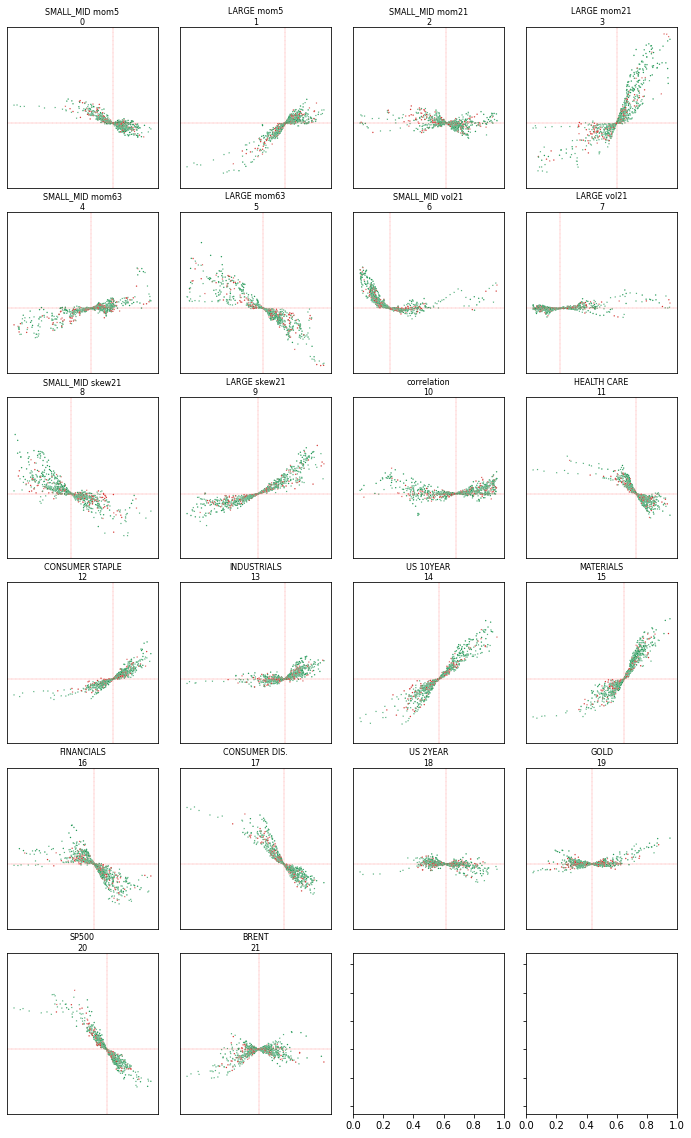

In [170]:
shap_values = ShapleyValueSampling(model_MLP)
attributes_train = shap_values.attribute(X_train).detach().numpy()

good_bad = good_bad_pred(model_MLP, X_train, y_train)

fig, axs = plt.subplots(math.ceil(len(features.columns) / 4), 4, figsize=(12, 20), sharex=False, sharey=True)
axs = axs.ravel()

for i, feature in enumerate(features.columns):
    df = pd.DataFrame(columns=['value', 'IG', 'good_bad', 'target', 'categorie'])
    df['value'] = X_train[:, i]
    df['IG'] = attributes_train[:, i]
    df['good_bad'] = good_bad
    df['target'] = y_train
    df.good_bad = df.good_bad.replace({0:'Bad', 1:'Good'})
    df.target = df.target.replace({0:'Large', 1:'Small'})
    
    sns.scatterplot(ax=axs[i], data=df, x='value', y='IG', hue='good_bad', style='target', s=2, legend=False,
                    palette=color_dict, edgecolors=None)
    
    axs[i].axvline(x=0., linestyle='--', color='r', lw=0.25)
    axs[i].axhline(y=0., linestyle='--', color='r', lw=0.25)
    axs[i].set_xlabel(None)
    axs[i].set_ylabel(None)
    axs[i].tick_params(axis='both', length=0, labelbottom=False, labelleft=False)
    axs[i].set_title(feature + '\n' + str(i), fontsize=8, pad=2)

# fig.delaxes(axs[-3])
# fig.delaxes(axs[-2])
# fig.delaxes(axs[-1])

plt.subplots_adjust(wspace=0.15, hspace=0.15)

plt.savefig('plots/MLP_features_importances_train.png', format='png', bbox_inches='tight', dpi=500, facecolor='white')
plt.show()

In [171]:
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

model = MLP(nbr_features, pdrop=dropout)
optimizer = torch.optim.Adam(model.parameters(), lr=eta, weight_decay=weight_decay)
criterion = nn.BCELoss()

train_set = TensorDataset(X_train, y_train)    
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)

for e in (tqdm(range(nb_epochs))):
    
    model.eval()
    train_accu = output_to_accu(model, X_train, y_train)
    ig = IntegratedGradients(model)
    attributes_train = ig.attribute(X_train, return_convergence_delta=False).detach().numpy()

    good_bad = good_bad_pred(model, X_train, y_train)
    fig, axs = plt.subplots(math.ceil(len(features.columns) / 4), 4, 
                            figsize=(12, 20), sharex=False, sharey=True, constrained_layout=True)
    axs = axs.ravel()
    for i, feature in enumerate(features.columns):
        df = pd.DataFrame(columns=['value', 'IG', 'good_bad', 'target', 'categorie'])
        df['value'] = X_train[:, i]
        df['IG'] = attributes_train[:, i] / np.abs(X_train[:, i])
        df['good_bad'] = good_bad
        df['target'] = y_train
        df.good_bad = df.good_bad.replace({0:'Bad', 1:'Good'})
        df.target = df.target.replace({0:'Large', 1:'Small'})

        sns.scatterplot(ax=axs[i], data=df, x='value', y='IG', hue='good_bad', style='target', s=3, legend=False,
                        palette=color_dict, edgecolors=None)

        axs[i].axvline(x=0., linestyle='--', color='r', lw=0.25)
        axs[i].axhline(y=0., linestyle='--', color='r', lw=0.25)
        axs[i].set_xlabel(None)
        axs[i].set_ylabel(None)
        axs[i].tick_params(axis='both', length=0, labelbottom=False, labelleft=False)
        axs[i].set_title(feature, fontsize=8, pad=2)

    # fig.delaxes(axs[-3])
    # fig.delaxes(axs[-2])
    # fig.delaxes(axs[-1])
    plt.suptitle(f'Epoch {e} ; {train_accu:.2f}% Accuracy', fontsize=12)
    plt.savefig('plots/film/' + f'epoch {e}' + '.png', format='png', bbox_inches='tight', facecolor='white')
    plt.close()
    
    model.train()
    for train_input, train_target in train_loader:
        optimizer.zero_grad()
        output = model(train_input)
        loss = criterion(output, train_target)
        loss.backward()
        optimizer.step()

  0%|          | 0/50 [00:00<?, ?it/s]


ZeroDivisionError: division by zero

In [ ]:
nb_epochs = 30

for num_feature in range(len(features.columns)):
    feature = features.columns[num_feature]

    model = MLP(nbr_features, pdrop=dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=eta, weight_decay=weight_decay)
    criterion = nn.BCELoss()

    train_set = TensorDataset(X_train, y_train)    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)

    fig, axs = plt.subplots(math.ceil(nb_epochs / 5), 5, 
                            figsize=(12, 15), sharex=True, sharey=True, constrained_layout=True)

    for e in (tqdm(range(nb_epochs))):

        model.eval()
        train_accu = output_to_accu(model, X_train, y_train)
        ig = IntegratedGradients(model)
        attributes_train = ig.attribute(X_train, return_convergence_delta=False).detach().numpy()

        good_bad = good_bad_pred(model, X_train, y_train)
        axs = axs.ravel()

        df = pd.DataFrame(columns=['value', 'IG', 'good_bad', 'target', 'categorie'])
        df['value'] = X_train[:, num_feature]
        df['IG'] = attributes_train[:, num_feature]
        df['good_bad'] = good_bad
        df['target'] = y_train
        df.good_bad = df.good_bad.replace({0:'Bad', 1:'Good'})
        df.target = df.target.replace({0:'Large', 1:'Small'})

        sns.scatterplot(ax=axs[e], data=df, x='value', y='IG', hue='good_bad', style='target', s=3, legend=False,
                        palette=color_dict, edgecolors=None)

        axs[e].axvline(x=0., linestyle='--', color='r', lw=0.25)
        axs[e].axhline(y=0., linestyle='--', color='r', lw=0.25)
        axs[e].set_xlabel(None)
        axs[e].set_ylabel(None)
        axs[e].tick_params(axis='both', length=0, labelbottom=False, labelleft=False)
        axs[e].set_title(f'Epoch {e} ; {train_accu:.2f}% Accuracy', fontsize=8, pad=2)

        model.train()
        for train_input, train_target in train_loader:
            optimizer.zero_grad()
            output = model(train_input)
            loss = criterion(output, train_target)
            loss.backward()
            optimizer.step()

    plt.suptitle(feature, fontsize=12)
    plt.savefig(f'plots/features/{feature}.png', format='png', bbox_inches='tight', facecolor='white', dpi=200)
    plt.close()

In [ ]:
from itertools import combinations

list_indices = [1, 10, 12, 13, 19, 20, 21]

results = []
train_accu = np.round(output_to_accu(model_MLP, X_train, y_train), 2)
test_accu = np.round(output_to_accu(model_MLP, X_test, y_test), 2)

for k in range(len(list_indices) + 1):
    for indices in combinations(list_indices, k):
        train_indices, test_indices, _, _ = train_test_split(range(len(y)), y, test_size=0.2, shuffle=False)
        X_train = X[train_indices]
        X_test = X[test_indices]
        X_train = X_train.sub_(X_mean).div_(X_std)
        X_test = X_test.sub_(X_mean).div_(X_std)
        for i in indices:
            X_test[:, i] = torch.zeros(len(X_test))
            X_train[:, i] = torch.zeros(len(X_train))
        results.append([str(indices), 
                        train_accu - np.round(output_to_accu(model_MLP, X_train, y_train), 2), 
                        test_accu - np.round(output_to_accu(model_MLP, X_test, y_test), 2)])

pd.DataFrame(results, columns=['Features Excluded', 'Train accuracy diff', 'Test accuracy diff']).sort_values('Test accuracy diff')

In [ ]:
good_bad = good_bad_pred(model_MLP, X_test, y_test)

fig, axs = plt.subplots(math.ceil(len(features.columns) / 4), 4, figsize=(8.27, 11.69), sharex=False, sharey=True)
axs = axs.ravel()

for i, feature in enumerate(features.columns):
    df = pd.DataFrame()
    df['value'] = X_test[:, i]
    df['IG'] = attributes_test[:, i] / np.sum(np.abs(attributes_test[:, i])) / np.abs(X_test[:, i])
    df['GOOD_BAD'] = good_bad
    df['target'] = y_test
    df.GOOD_BAD = df.GOOD_BAD.replace({0:'Bad', 1:'Good'})
    df.target = df.target.replace({0:'Small', 1:'Large'})
    
    sns.scatterplot(ax=axs[i], data=df, x='value', y='IG', hue='GOOD_BAD', s=2, style='target',
                    palette=list(reversed(pal)), legend=False, edgecolors=None)
    
    axs[i].axvline(x=0., linestyle='--', color='r', lw=0.25)
    axs[i].axhline(y=0., linestyle='--', color='r', lw=0.25)
    axs[i].tick_params(axis='both', length=0, labelbottom=False, labelleft=False)
    axs[i].set_xlabel(None)
    axs[i].set_ylabel(None)
    axs[i].set_title(feature, fontsize=3, pad=2)

# fig.delaxes(axs[-3])
# fig.delaxes(axs[-2])
# fig.delaxes(axs[-1])

plt.subplots_adjust(wspace=0.15, hspace=0.15)
plt.savefig('plots/MLP_features_importances_test.png', format='png', bbox_inches='tight', dpi=500, facecolor='white')

plt.show()

In [ ]:
cond = LayerConductance(model_MLP, model_MLP.relu1)
cond_vals_train = cond.attribute(X_train).detach().numpy()
cond_vals_test = cond.attribute(X_test).detach().numpy()

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

sns.barplot(ax=axs[0], x=np.abs(cond_vals_train).mean(axis=0), y=np.arange(hidden_size), color='r', orient='h')
axs[0].tick_params(length=0)
axs[0].set_title('Train set')

sns.barplot(ax=axs[1], x=np.abs(cond_vals_test).mean(axis=0), y=np.arange(hidden_size), color='r', orient='h')
axs[1].tick_params(length=0)
axs[1].set_title('Test set')

plt.tight_layout()
plt.show()

In [ ]:
cond = LayerConductance(model_MLP, model_MLP.relu2)
cond_vals_train = cond.attribute(X_train).detach().numpy()
cond_vals_test = cond.attribute(X_test).detach().numpy()

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

sns.barplot(ax=axs[0], x=np.abs(cond_vals_train).mean(axis=0), y=np.arange(hidden_size), color='r', orient='h')
axs[0].tick_params(length=0)
axs[0].set_title('Train set')

sns.barplot(ax=axs[1], x=np.abs(cond_vals_test).mean(axis=0), y=np.arange(hidden_size), color='r', orient='h')
axs[1].tick_params(length=0)
axs[1].set_title('Test set')

plt.tight_layout()
plt.show()

In [ ]:
cond = LayerConductance(model_MLP, model_MLP.relu3)
cond_vals_train = cond.attribute(X_train).detach().numpy()
cond_vals_test = cond.attribute(X_test).detach().numpy()

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

sns.barplot(ax=axs[0], x=np.abs(cond_vals_train).mean(axis=0), y=np.arange(hidden_size), color='r', orient='h')
axs[0].tick_params(length=0)
axs[0].set_title('Train set')

sns.barplot(ax=axs[1], x=np.abs(cond_vals_test).mean(axis=0), y=np.arange(hidden_size), color='r', orient='h')
axs[1].tick_params(length=0)
axs[1].set_title('Test set')

plt.tight_layout()
plt.show()

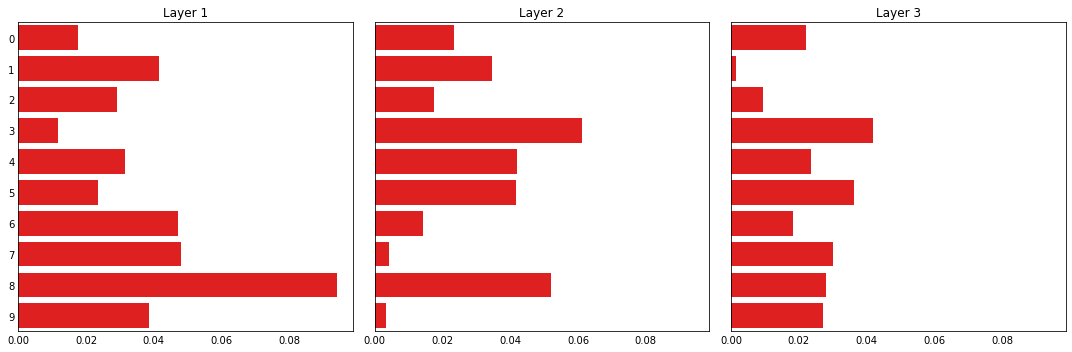

In [110]:
cond1 = LayerConductance(model_MLP, model_MLP.relu1)
cond_vals_train1 = cond1.attribute(X_train).detach().numpy()

cond2 = LayerConductance(model_MLP, model_MLP.relu2)
cond_vals_train2 = cond2.attribute(X_train).detach().numpy()

cond3 = LayerConductance(model_MLP, model_MLP.relu3)
cond_vals_train3 = cond3.attribute(X_train).detach().numpy()

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True, sharex=True)

sns.barplot(ax=axs[0], x=np.abs(cond_vals_train1).mean(axis=0), y=np.arange(hidden_size), color='r', orient='h')
axs[0].tick_params(length=0)
axs[0].set_title('Layer 1')

sns.barplot(ax=axs[1], x=np.abs(cond_vals_train2).mean(axis=0), y=np.arange(hidden_size), color='r', orient='h')
axs[1].tick_params(length=0)
axs[1].set_title('Layer 2')

sns.barplot(ax=axs[2], x=np.abs(cond_vals_train3).mean(axis=0), y=np.arange(hidden_size), color='r', orient='h')
axs[2].tick_params(length=0)
axs[2].set_title('Layer 3')

plt.tight_layout()
plt.show()

# Time series as an input

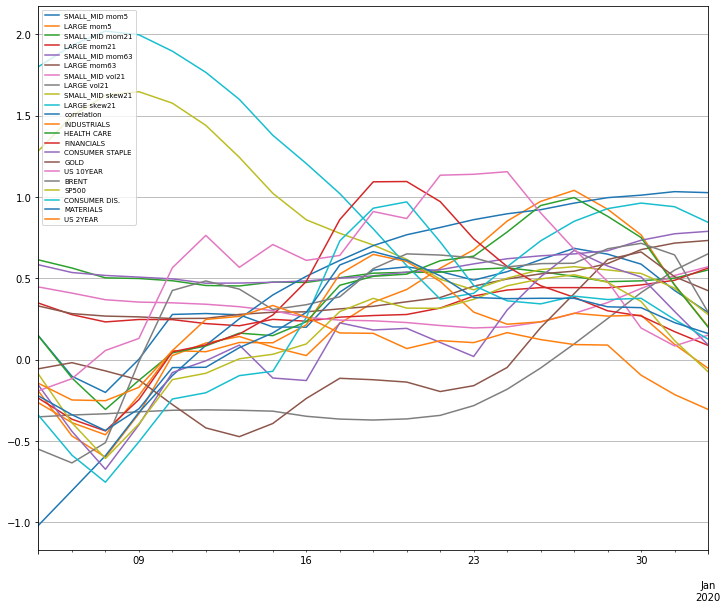

In [66]:
features_standardized = (features - features.mean()) / features.std()
fig, ax = plt.subplots(figsize=(12, 10))
features_standardized[-21:].plot(ax=ax)
plt.legend(fontsize=7)
plt.grid()
plt.show()

In [ ]:
class RNN(nn.Module):

    def __init__(self, nbr_features, hidden_size, num_layers, pdrop=0.):
        super(RNN, self).__init__()
        
        self.nbr_features = nbr_features
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = pdrop
        self.device = device
        self.rnn = nn.RNN(input_size=self.nbr_features, hidden_size=self.hidden_size, 
                            num_layers=self.num_layers, batch_first=True, dropout=self.dropout)
        self.fc = nn.Linear(hidden_size, 1)

        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = x.view(x.size(0), x.size(1), x.size(2))
        x, _ = self.rnn(x)
        x = self.sigmoid(self.fc(x[:, -1, :]))

        return x.squeeze()


class GRU(nn.Module):

    def __init__(self, nbr_features, hidden_size=10, num_layers=1, pdrop=0.):
        super(GRU, self).__init__()
        
        self.nbr_features = nbr_features
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = pdrop
        self.device = device
        self.gru = nn.GRU(input_size=self.nbr_features, hidden_size=self.hidden_size, 
                            num_layers=self.num_layers, batch_first=True, dropout=self.dropout)
        self.fc = nn.Linear(hidden_size, 1)

        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = x.view(x.size(0), x.size(1), x.size(2))
        x, _ = self.gru(x)
        x = self.sigmoid(self.fc(x[:, -1, :]))

        return x.squeeze()


class LSTM(nn.Module):

    def __init__(self, nbr_features, hidden_size=10, num_layers=1, pdrop=0.):
        super(LSTM, self).__init__()
        
        self.nbr_features = nbr_features
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = pdrop
        self.device = device
        self.lstm = nn.LSTM(input_size=self.nbr_features, hidden_size=self.hidden_size, 
                            num_layers=self.num_layers, batch_first=True, dropout=self.dropout)
        self.fc = nn.Linear(hidden_size, 1)

        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = x.view(x.size(0), x.size(1), x.size(2))
        x, _ = self.lstm(x)
        x = self.sigmoid(self.fc(x[:, -1, :]))

        return x.squeeze()

In [ ]:
input_period = 10

num_features = len(features.columns)

df_input = features.loc[:df_output.index[-1]]

X = []
for idx in df_output.index:
    df_input_period = df_input.loc[:idx].iloc[-input_period:]
    X_period = df_input_period.values.reshape(input_period, num_features)
    X.append(X_period)

X = np.array(X)
y = df_output.values

X, y = torch.from_numpy(X).float(), torch.from_numpy(y).float()

train_indices, test_indices, _, _ = train_test_split(range(len(y)), y, test_size=0.2, shuffle=False)
X_train, y_train, X_test, y_test = X[train_indices], y[train_indices], X[test_indices], y[test_indices]
print('Number of train sample', len(X_train))
print('Number of test sample', len(X_test))

X_mean = X_train.mean(dim=[0, 1], keepdim=True)
X_std = X_train.std(dim=[0, 1], keepdim=True)
X_train = X_train.sub_(X_mean).div_(X_std)
X_test = X_test.sub_(X_mean).div_(X_std)

class_count_train = np.unique(y_train.cpu(), axis=0, return_counts=True)[1]
class_count_test = np.unique(y_test.cpu(), axis=0, return_counts=True)[1]
weights_train = torch.tensor(class_count_train / sum(class_count_train))
weights_test = torch.tensor(class_count_test / sum(class_count_test))
print('Allocation of best returns in train set :', weights_train.cpu().numpy())
print('Allocation of best returns in test set :', weights_test.cpu().numpy())

In [ ]:
eta = 1e-3
weight_decay = 1e-4
dropout = 0.
batch_size = 50
nb_epochs = 30

verbose = 3

nbr_features = X.size(2)
hidden_size = 10
num_layers = 1

model_RNN = RNN(nbr_features, hidden_size=hidden_size, num_layers=num_layers, pdrop=dropout)
model_GRU = GRU(nbr_features, hidden_size=hidden_size, num_layers=num_layers, pdrop=dropout)
model_LSTM = LSTM(nbr_features, hidden_size=hidden_size, num_layers=num_layers, pdrop=dropout)

train(model_RNN, X_train, y_train, nb_epochs=nb_epochs, X_test=X_test, y_test=y_test, 
      batch_size=batch_size, eta=eta, weight_decay=weight_decay, verbose=verbose)
train(model_GRU, X_train, y_train, nb_epochs=nb_epochs, X_test=X_test, y_test=y_test, 
      batch_size=batch_size, eta=eta, weight_decay=weight_decay, verbose=verbose)
train(model_LSTM, X_train, y_train, nb_epochs=nb_epochs, X_test=X_test, y_test=y_test, 
      batch_size=batch_size, eta=eta, weight_decay=weight_decay, verbose=verbose)

model_RNN.eval()
print(f' RNN Accuracy on train set : {output_to_accu(model_RNN, X_train, y_train):.2f} %')
print(f' RNN Accuracy on test set : {output_to_accu(model_RNN, X_test, y_test):.2f} %')

model_GRU.eval()
print(f' GRU Accuracy on train set : {output_to_accu(model_GRU, X_train, y_train):.2f} %')
print(f' GRU Accuracy on test set : {output_to_accu(model_GRU, X_test, y_test):.2f} %')

model_LSTM.eval()
print(f' LSTM Accuracy on train set : {output_to_accu(model_LSTM, X_train, y_train):.2f} %')
print(f' LSTM Accuracy on test set : {output_to_accu(model_LSTM, X_test, y_test):.2f} %')

In [ ]:
model_list = [model_RNN, model_GRU, model_LSTM]

fig, axs = plt.subplots(3, 1, figsize=(20, 40), sharex=True, sharey=True)
for ax, model in zip(axs, model_list):
    ig = IntegratedGradients(model)
    attributes_train = ig.attribute(X_train, return_convergence_delta=False).detach().numpy()

    attr = np.mean(np.abs(attributes_train), axis=0).T

    sns.heatmap(ax=ax, data=attr, annot=False, cmap='Reds', cbar=False, 
                yticklabels=features.columns, xticklabels=list(reversed(- (np.arange(input_period)))))

    ax.tick_params(axis='both', which='major', labelsize=8, labeltop=True, labelbottom=False, rotation=0, length=0)
    ax.set_title(model.__class__.__name__, fontsize=20)

plt.show()

In [ ]:
ig = IntegratedGradients(model_LSTM)
attributes_train = ig.attribute(X_train, return_convergence_delta=False).detach().numpy()
attributes_test = ig.attribute(X_test, return_convergence_delta=False).detach().numpy()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 15), sharey=True, sharex=True)

attr_train = np.sum(np.mean(np.abs(attributes_train), axis=0), axis=0)
attr_test = np.sum(np.mean(np.abs(attributes_test), axis=0), axis=0)

sns.barplot(ax=axs[0], x=attr_train, y=features.columns, color='r')
axs[0].tick_params(length=0, labelsize=8)
axs[0].set_title('Train set')

sns.barplot(ax=axs[1], x=attr_test, y=features.columns, color='r')
axs[1].tick_params(length=0, labelsize=8)
axs[1].set_title('Test set')

plt.tight_layout()
plt.show()

In [ ]:
good_bad = good_bad_pred(model_LSTM, X_train, y_train)

fig, axs = plt.subplots(math.ceil(len(features.columns) / 4), 4, figsize=(8.27, 11.69), sharex=False, sharey=True)
axs = axs.ravel()

for i, feature in enumerate(features.columns):
    df = pd.DataFrame()
    df['value'] = X_train.mean(axis=1)[:, i]
    df['IG'] = np.sum(attributes_train, axis=1)[:, i]
    df['GOOD_BAD'] = good_bad
    df.GOOD_BAD = df.GOOD_BAD.replace({0:'Bad', 1:'Good'})
    df['target'] = y_train
    
    sns.scatterplot(ax=axs[i], data=df, x='value', y='IG', hue='GOOD_BAD', style='target',
                    s=2, legend=False, edgecolors=None, palette=color_dict)
    
    axs[i].axvline(x=0., linestyle='--', color='r', lw=0.25)
    axs[i].axhline(y=0., linestyle='--', color='r', lw=0.25)
    axs[i].set_xlabel(None)
    axs[i].set_ylabel(None)
    axs[i].tick_params(axis='both', length=0, labelbottom=False, labelleft=False)
    axs[i].set_title(feature, fontsize=3, pad=2)

# fig.delaxes(axs[-3])
# fig.delaxes(axs[-2])
# fig.delaxes(axs[-1])

plt.subplots_adjust(wspace=0.15, hspace=0.15)

plt.savefig('plots/LSTM_features_importances_train.png', format='png', bbox_inches='tight', dpi=500, facecolor='white')
plt.show()

In [ ]:
good_bad = good_bad_pred(model_LSTM, X_test, y_test)

fig, axs = plt.subplots(math.ceil(len(features.columns) / 4), 4, figsize=(8.27, 11.69), sharex=False, sharey=True)
axs = axs.ravel()

for i, feature in enumerate(features.columns):
    df = pd.DataFrame()
    df['value'] = X_test.mean(axis=1)[:, i]
    df['IG'] = np.sum(attributes_test, axis=1)[:, i]
    df['GOOD_BAD'] = good_bad
    df.GOOD_BAD = df.GOOD_BAD.replace({0:'Bad', 1:'Good'})
    df['target'] = y_test
    
    sns.scatterplot(ax=axs[i], data=df, x='value', y='IG', hue='GOOD_BAD', style='target',
                    s=2, legend=False, edgecolors=None, palette=color_dict)
    
    axs[i].axvline(x=0., linestyle='--', color='r', lw=0.25)
    axs[i].axhline(y=0., linestyle='--', color='r', lw=0.25)
    axs[i].set_xlabel(None)
    axs[i].set_ylabel(None)
    axs[i].tick_params(axis='both', length=0, labelbottom=False, labelleft=False)
    axs[i].set_title(feature, fontsize=3, pad=2)

# fig.delaxes(axs[-3])
# fig.delaxes(axs[-2])
# fig.delaxes(axs[-1])

plt.subplots_adjust(wspace=0.15, hspace=0.15)

plt.savefig('plots/LSTM_features_importances_test.png', format='png', bbox_inches='tight', dpi=500, facecolor='white')
plt.show()

In [ ]:
fix, ax = plt.subplots(figsize=(15, 5))

plt.plot(model_LSTM(X_train).detach().numpy()[-252:])
ax.axhline(y=0.65, linestyle='--', color='r')
ax.axhline(y=0.35, linestyle='--', color='r')
plt.show()

In [ ]:
df_prob = pd.DataFrame(model_LSTM(X_train)[-252:].detach())
portfolio = pd.DataFrame(index=df_prob.index, columns=['SMALL_MID', 'LARGE']).fillna(0)

portfolio['SMALL_MID'] = (df_prob > 0.7).astype(int) - (df_prob < 0.3).astype(int)
portfolio['LARGE'] = - portfolio.SMALL_MID
portfolio.head()

In [ ]:
df_trade = pd.DataFrame(index=df_prob.index)
df_trade['small'] = (df_prob > 0.7).astype(int)
df_trade['large'] = (df_prob < 0.3).astype(int)

for i in range(len(df_trade)):
    if df_trade.small.iloc[i] == 1:
        df_trade.at[i, 'strat'] = 1
    elif df_trade.large.iloc[i] == 1:
        df_trade.at[i, 'strat'] = 0
    else:
        df_trade.at[i, 'strat'] = np.nan

df_trade.strat = df_trade.strat.fillna(method='ffill')
df_trade.head(20)